---
title: First attempt of comparing predicted vs observed gene expression
description: In this run, we centered enformer predictions around start and end for each gene. The plots show no association, but we will continue to use this template for plotting CAGE expression as we refine our approach to choosing genes for examination.
author: Sabrina Mi
date: 8/3/23
---

In [13]:
gene_expr_bed = "/home/s1mi/enformer_rat_data/Brain.rn7.expr.tpm.bed"

import pandas as pd
import numpy as np
obs_gene_expr = pd.read_csv(gene_expr_bed, sep="\t", header=0, index_col='gene_id')

/tmp/ipykernel_156512/1612639889.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_gene_expr = pd.read_csv(gene_expr_bed, sep="\t", header=0, index_col='gene_id')


In [14]:
gene_list = ['ENSRNOG00000001342', 'ENSRNOG00000020624', 'ENSRNOG00000058006', 'ENSRNOG00000060045']
#print(obs_gene_expr.loc[gene_list])

pred_vs_obs = {}
for gene in gene_list:
    obs = obs_gene_expr.loc[gene][3:]
    pred_vs_obs[gene] = pd.DataFrame({"observed": obs, "predicted": np.zeros(obs.shape)})

In [12]:
def compute_tss_bin(output_window_coords_resized, tss_position, output_length=114688, bin_length=128, rc=False):
    '''
    Computes the bin index of the enformer output bin containing the TSS
    Inputs:
    output_window_coords_resized: Kipoiseq interval for the output window of Enformer, should already be resized to the model output window size
    tss_position: absolute location of TSS
    output_length: Length of output window in base pairs
    bin_size: Length of output bins in base pairs
    Outputs:
    tss_bin: Index of bin containing TSS
    '''
    try:
        relative_position = int(tss_position) - int(output_window_coords_resized.start)
    except:
    # print(tss_position)
    # print(output_window_coords_resized.start)
        sys.exit()

    if relative_position < 0 or relative_position > output_length:
        # print(tss_position, "appears to be out of bounds for output window: ",output_window_coords_resized)
        return None 
    else:
        center = relative_position // bin_length

        
        if rc:
            number_of_bins = int(output_length/bin_length)
            new_center = number_of_bins - 1 - center
            # print(new_center)
            return [new_center-1,new_center,new_center+1]
        else:
            # print(center)
            return [center-1,center,center+1]

In [6]:
annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/rn7.gene.txt", sep="\t", index_col='geneId')
print(annot_df.loc[gene_list])

                            geneSymbol chromosome      start        end  \
geneId                                                                    
ENSRNOG00000001342  ENSRNOG00000001342         12   33261476   33293932   
ENSRNOG00000020624              Acadsb          1  186188987  186230379   
ENSRNOG00000058006                Sncg         16    9700514    9705368   
ENSRNOG00000060045               Pi4ka         11   83609069   83724080   

                   strand        tss  \
geneId                                 
ENSRNOG00000001342      -   33293932   
ENSRNOG00000020624      +  186188987   
ENSRNOG00000058006      -    9705368   
ENSRNOG00000060045      +   83609069   

                                                     description  hasEqtl  \
geneId                                                                      
ENSRNOG00000001342     cilia and flagella associated protein 251     True   
ENSRNOG00000020624  acyl-CoA dehydrogenase, short/branched chain     True   


/tmp/ipykernel_156512/3990301426.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/rn7.gene.txt", sep="\t", index_col='geneId')


In [15]:
import kipoiseq # for manipulating fasta files
from kipoiseq import Interval # same as above, really
import sys
import h5py
predictions_dir = "/home/s1mi/enformer_rat_pipeline/predictions_folder/personalized_enformer_minimal_some_regions/predictions_2023-07-26/enformer_predictions"


for gene in gene_list:
    print(gene)
    gene_annot = annot_df.loc[gene]
    interval_obj = Interval("chr" + str(gene_annot['chromosome']), gene_annot['start'], gene_annot['end'])
    tss_bins = compute_tss_bin(interval_obj.resize(114688), gene_annot['tss'])
    if tss_bins is None:
        print("Skipping", gene)
        continue
    interval = f"chr{gene_annot['chromosome']}_{gene_annot['start']}_{gene_annot['end']}"
    i=0
    for individual in pred_vs_obs[gene].index:
        predictions = h5py.File(f"{predictions_dir}/{individual}/haplotype1/{interval}_predictions.h5", "r")
        matrix = predictions[interval][()]
        extra_bins =  [tss_bins[0] - 1] + tss_bins + [tss_bins[2] + 1]
        if i < 5:
            print(matrix[extra_bins, 4980])
            i += 1
        pred_expr = np.average(matrix[tss_bins, 4980])
        pred_vs_obs[gene].loc[individual, "predicted"] = pred_expr

    


ENSRNOG00000001342
[0.00573627 0.00507914 0.0072732  0.00559864 0.00767822]
[0.00573627 0.00507914 0.0072732  0.00559864 0.00767822]
[0.00573627 0.00507914 0.0072732  0.00559864 0.00767822]
[0.00573627 0.00507914 0.0072732  0.00559864 0.00767822]
[0.00573627 0.00507914 0.0072732  0.00559864 0.00767822]
ENSRNOG00000020624
[5.7827654  4.293017   7.8872423  0.10644712 0.05631344]
[5.7819533  4.290507   7.8848658  0.10634203 0.05630142]
[5.7827654  4.293017   7.8872423  0.10644712 0.05631344]
[5.7827654  4.293017   7.8872423  0.10644712 0.05631344]
[5.7827654  4.293017   7.8872423  0.10644712 0.05631344]
ENSRNOG00000058006
[1.4247483e+01 5.7383850e-02 1.2978141e-02 9.7031957e-03 1.5117653e-02]
[1.42411528e+01 5.73353358e-02 1.29730888e-02 9.69883148e-03
 1.51052885e-02]
[1.4247483e+01 5.7383850e-02 1.2978141e-02 9.7031957e-03 1.5117653e-02]
[1.4247483e+01 5.7383850e-02 1.2978141e-02 9.7031957e-03 1.5117653e-02]
[1.4247483e+01 5.7383850e-02 1.2978141e-02 9.7031957e-03 1.5117653e-02]
ENSRNOG

In [18]:
print(pred_vs_obs)

{'ENSRNOG00000001342':            observed  predicted
000789972A     7.53   0.005984
0007899884    11.35   0.005984
000789FF64     9.33   0.005984
00079298B1     9.88   0.005984
00079299B5      9.9   0.005984
...             ...        ...
00079FF7D6     7.63   0.005984
0007899826     2.83   0.005984
0007929917     8.29   0.005984
00077E82E3    10.05   0.005985
00078A18A7     6.73   0.005984

[340 rows x 2 columns], 'ENSRNOG00000020624':            observed  predicted
000789972A    44.43   4.095569
0007899884    50.12   4.093905
000789FF64    62.47   4.095569
00079298B1    64.97   4.095569
00079299B5    57.53   4.095569
...             ...        ...
00079FF7D6     53.3   4.093905
0007899826    52.88   4.093905
0007929917    54.19   4.093905
00077E82E3    74.91   4.095569
00078A18A7     50.0   4.093905

[340 rows x 2 columns], 'ENSRNOG00000058006':            observed  predicted
000789972A    75.75   0.026688
0007899884    98.29   0.026669
000789FF64     26.2   0.026688
00079298B1    9

000789972A    44.43
0007899884    50.12
000789FF64    62.47
00079298B1    64.97
00079299B5    57.53
              ...  
00079FF7D6     53.3
0007899826    52.88
0007929917    54.19
00077E82E3    74.91
00078A18A7     50.0
Name: observed, Length: 340, dtype: object


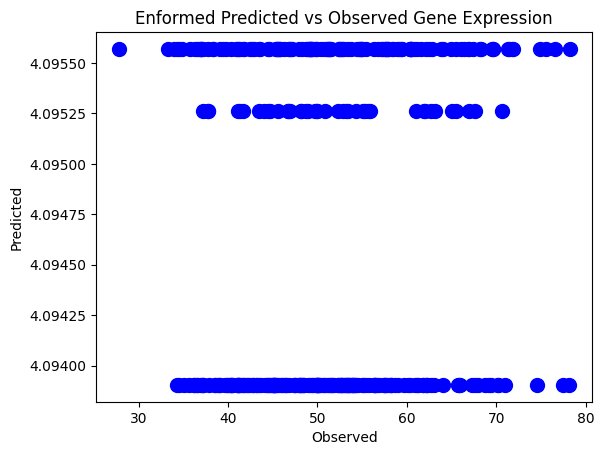

In [23]:
import matplotlib.pyplot as plt
df = pred_vs_obs['ENSRNOG00000020624']
print(df['observed'])

from scipy.stats import zscore
x = df['observed']
y = df['predicted']
# Create the dot plot
plt.scatter(x, y, color='blue', marker='o', s=100)




# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Enformed Predicted vs Observed Gene Expression')

# Show the plot
plt.show()

### How we could improve plots:

* Use all 340 individuals (instead of the 80 that I moved to Box before polaris shut down)
* Rerun predictions with sequences centered at TSS (instead of gene start and end)
* The upside is that the Enformer predictions so far agree with basic expectations:
    * There is variation in predicted gene expression between individuals (although slim)
    * CAGE expression peaks around TSS and tapers off



### Extra Plots

In [24]:
# predixcan = '/Users/sabrinami/Library/CloudStorage/Box-Box/imlab-data/data-Github/rat-genomic-analysis/PTRS-Analysis/RatXcan/Results/Br_EN__predict.txt'
# pred_gene_expr = pd.read_csv(predixcan, sep="\t", header=0, index_col='IID')
# pred_gene_expr = pred_gene_expr.loc[individuals]



In [112]:
print(pred_gene_expr[[gene]].join(df['predicted'], how='inner'))

            ENSRNOG00000060045  predicted
00077E90D8            1.286916   4.095569
00078997FE            0.011189   4.095569
00079FF7D6            2.644286   4.093905
00078A1A62            0.009481   4.093905
000792A3F9            2.646413   4.093905
...                        ...        ...
00078A072C            0.009487   4.093905
000792A07E            1.288204   4.095264
000792A420            1.370338   4.093905
00078997BF            0.009408   4.093905
00077E7666            0.010847   4.095569

[80 rows x 2 columns]


In [25]:
# gene = 'ENSRNOG00000020624'
# df = pred_vs_obs[gene]
# df = pred_gene_expr[[gene]].join(df['predicted'], how = 'inner')
# print(df)

# from scipy.stats import zscore
# x = zscore(df[gene])
# y = zscore(df['predicted'])
# # Create the dot plot
# plt.scatter(x, y, color='blue', marker='o', s=100)



NameError: name 'pred_gene_expr' is not defined

In [26]:
df = pred_vs_obs['ENSRNOG00000001342']


from scipy.stats import zscore
x = zscore(df['observed'])
y = zscore(df['predicted'])
# Create the dot plot
plt.scatter(x, y, color='blue', marker='o', s=100)




# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Enformed Predicted vs Observed Gene Expression')

# Show the plot
plt.show()

TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable sqrt method

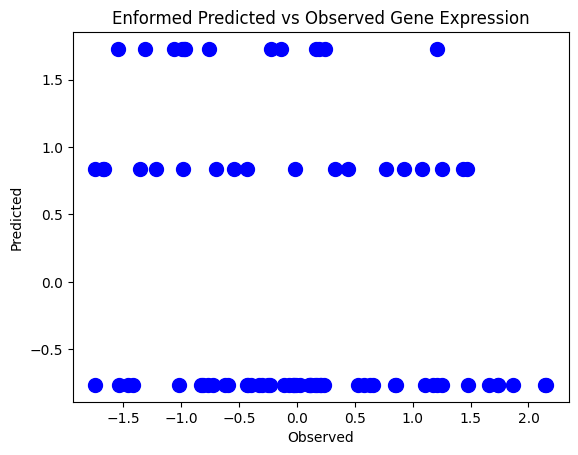

In [90]:
import matplotlib.pyplot as plt
df = pred_vs_obs['ENSRNOG00000058006']


from scipy.stats import zscore
x = zscore(df['observed'])
y = zscore(df['predicted'])
# Create the dot plot
plt.scatter(x, y, color='blue', marker='o', s=100)




# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Enformed Predicted vs Observed Gene Expression')

# Show the plot
plt.show()